# Model Evaluation

##### *In which we hope all the work we put into our model pays off.*

###### [GitHub Repository](https://github.com/ahester57/ai_workshop/tree/master/notebooks/time_for_crab/3-evaluation)

###### [Notebook Viewer](https://nbviewer.jupyter.org/github/ahester57/ai_workshop/blob/master/notebooks/time_for_crab/3-evaluation/evaluation.ipynb)

###### [Kaggle Dataset](https://www.kaggle.com/sidhus/crab-age-prediction)


## Introduction

In this notebook, we will evaluate the performance of our model. We will use the following metrics:

### Regression Metrics

Throughout this notebook, we will use the following metrics to evaluate the regression model:

#### Mean Squared Error
 
- The best score is 0.0
- Lower is better.
- Larger errors are penalized more than smaller errors.

#### Mean Absolute Error

- The best score is 0.0
- Lower is better.
- Less sensitive to outliers.

#### Explained Variance Score

- The best score is 1.0
- Lower is worse.

#### R2 Score

- The best score is 1.0
- Lower is worse.

From the [scikit-learn documentation](https://scikit-learn.org/stable/modules/generated/sklearn.metrics.explained_variance_score.html):

> **Note**: The Explained Variance score is similar to the `R^2 score`, with the notable difference that it does not account for systematic offsets in the prediction.
> Most often the `R^2 score` should be preferred.


### Define Constants

In [17]:
%%time
CACHE_FILE = '../cache/designrcrabs.feather'
NEXT_NOTEBOOK = '../Hester-CS5300-Time-for-Crab.ipynb'
MODEL_CHECKPOINT_FILE = '../cache/designr_eval.weights.h5'

PREDICTION_TARGET = 'Age'    # 'Age' is predicted
DATASET_COLUMNS = ['Sex_F','Sex_M','Sex_I','Length','Diameter','Height','Weight','Shucked Weight','Viscera Weight','Shell Weight',PREDICTION_TARGET]
REQUIRED_COLUMNS = [PREDICTION_TARGET]

NUM_EPOCHS = 1000
VALIDATION_SPLIT = 0.2
NUM_HIDDEN_LAYERS = 1
NUM_UNITS = 8


CPU times: total: 0 ns
Wall time: 0 ns


### Import Libraries

In [18]:
%%time
from notebooks.time_for_crab.mlutils import display_df, generate_neural_network, generate_neural_pyramid
from notebooks.time_for_crab.mlutils import plot_training_loss, plot_training_loss_from_dict, plot_true_vs_pred_from_dict
from notebooks.time_for_crab.mlutils import score_combine, score_comparator, score_model

import keras

keras_backend = keras.backend.backend()
print(f'Keras version: {keras.__version__}')
print(f'Keras backend: {keras_backend}')
if keras_backend == 'tensorflow':
    import tensorflow as tf
    print(f'TensorFlow version: {tf.__version__}')
    print(f'TensorFlow devices: {tf.config.list_physical_devices()}')
elif keras_backend == 'torch':
    import torch
    print(f'Torch version: {torch.__version__}')
    print(f'Torch devices: {torch.cuda.get_device_name(torch.cuda.current_device())}')
    # torch supports windows-native cuda, but CPU was faster for this task
elif keras_backend == 'jax':
    import jax
    print(f'JAX version: {jax.__version__}')
    print(f'JAX devices: {jax.devices()}')
else:
    print('Unknown backend; Proceed with caution.')

import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns

pd.set_option('mode.copy_on_write', True)


Keras version: 3.3.3
Keras backend: tensorflow
TensorFlow version: 2.16.1
TensorFlow devices: [PhysicalDevice(name='/physical_device:CPU:0', device_type='CPU')]
CPU times: total: 0 ns
Wall time: 997 µs


### Load Data from Cache

In the [feature importance section](../2-features/features.ipynb), we saved the life of the crabs by removing the features which killed the crab.


In [19]:
%%time
crabs = pd.read_feather(CACHE_FILE)
crabs_test = pd.read_feather(CACHE_FILE.replace('.feather', '_test.feather'))

display_df(crabs, show_distinct=True)

# split features from target
X_train = crabs.drop([PREDICTION_TARGET], axis=1)
y_train = crabs[PREDICTION_TARGET]

X_test = crabs_test.drop([PREDICTION_TARGET], axis=1)
y_test = crabs_test[PREDICTION_TARGET]

print(f'X_train: {X_train.shape}')
print(f'X_test: {X_test.shape}')


DataFrame shape: (3031, 9)
First 5 rows:
        Length  Diameter    Height    Weight  Shell Weight  Sex_F  Sex_I  \
3483  1.724609  1.312500  0.500000  50.53125     13.070312  False  False   
993   1.612305  1.312500  0.500000  41.09375     14.320312   True  False   
1427  1.650391  1.262695  0.475098  40.78125      5.046875  False  False   
3829  1.362305  1.150391  0.399902  25.43750      9.781250  False  False   
1468  1.250000  0.924805  0.375000  30.09375      8.390625  False  False   

      Sex_M  Age  
3483   True   12  
993   False   13  
1427   True   11  
3829   True   10  
1468   True    9  
<class 'pandas.core.frame.DataFrame'>
Index: 3031 entries, 3483 to 658
Data columns (total 9 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   Length        3031 non-null   float16
 1   Diameter      3031 non-null   float16
 2   Height        3031 non-null   float16
 3   Weight        3031 non-null   float16
 4   Shell Weight  3031 non

## Time for Crab!

Get that pot of water ready. It's crab cookin' time.

![Crab pot](https://chefscornerstore.com/product_images/uploaded_images/steaming-crabs.jpg)


## Rebuild our Model

We will rebuild our model using the same parameters as before.


In [20]:
all_models = {
    'designr':
        generate_neural_network(
            X_train,
            num_hidden_layers=NUM_HIDDEN_LAYERS,
            num_units=NUM_UNITS)}

all_models['designr'].compile(
    optimizer=keras.optimizers.Nadam(learning_rate=0.01),
    loss='mean_squared_error')

designr_checkpoint = keras.callbacks.ModelCheckpoint(
    MODEL_CHECKPOINT_FILE,
    save_best_only=True,
    save_weights_only=True,
    monitor='val_loss',
    mode='min')

all_models['designr'].summary()


Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ normalization_2 (Normalization) │ (None, 8)              │            17 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 8)              │            72 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 1)              │             9 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 98 (396.00 B)

 Trainable params: 81 (324.00 B)

 Non-trainable params: 17 (72.00 B)

### Train for 1000 Epochs

brb...


CPU times: total: 1.19 s
Wall time: 8.26 s


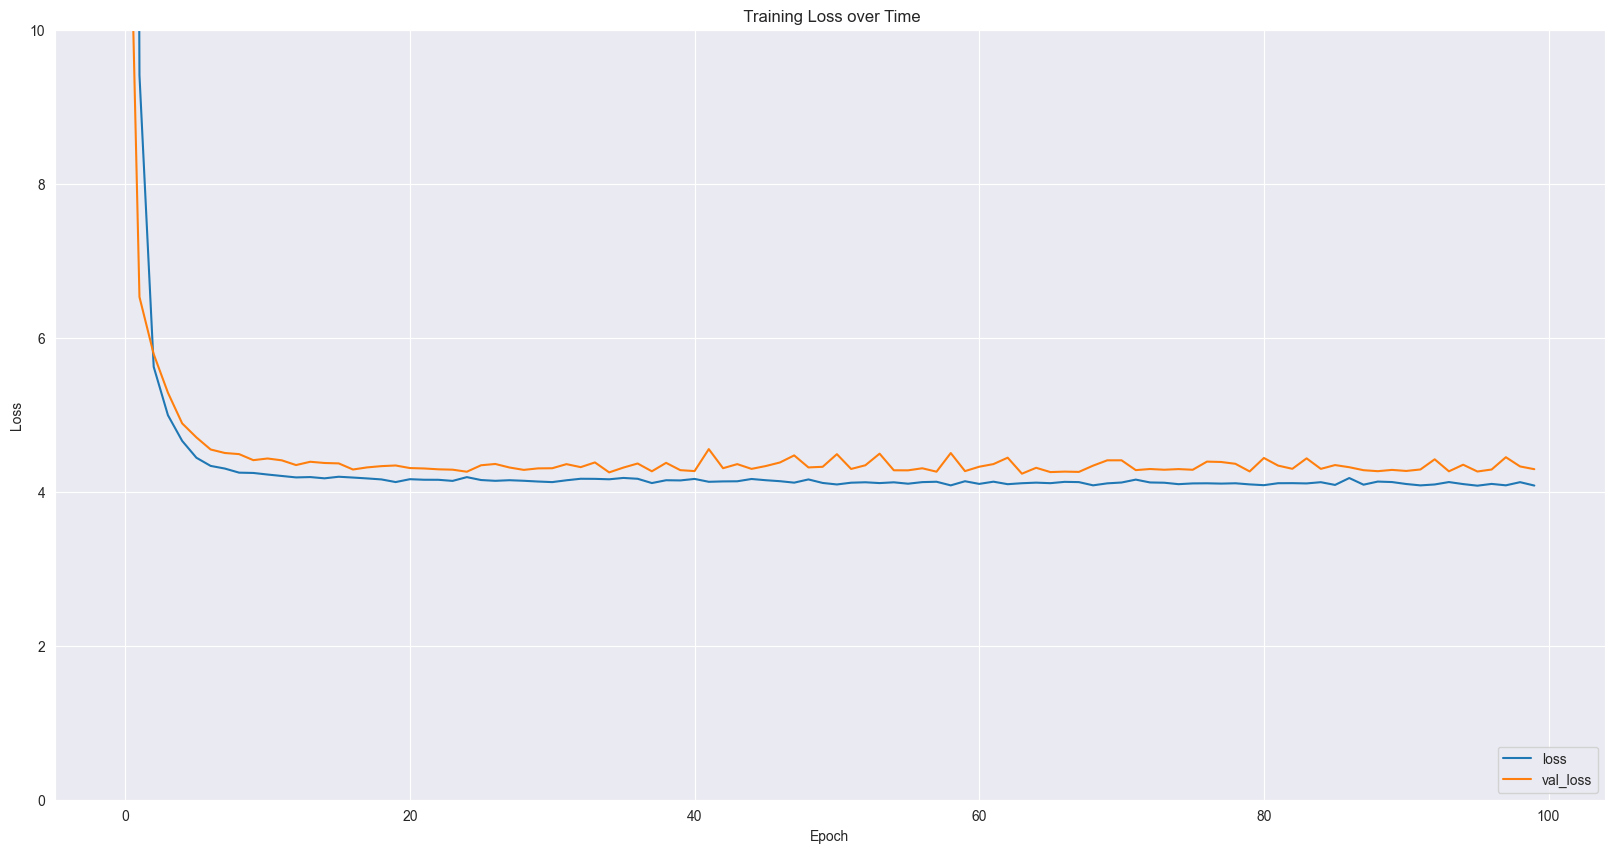

In [22]:
%%time
designr_history = all_models['designr'].fit(
    X_train,
    y_train,
    epochs=NUM_EPOCHS,
    validation_split=VALIDATION_SPLIT,
    callbacks=[designr_checkpoint],
    verbose=0)

all_models['designr'].load_weights(MODEL_CHECKPOINT_FILE)

plot_training_loss(designr_history)


## Regression Model Evaluation

Recall our scores from the [model selection section](../1-model/model.ipynb):

| Model            | Mean Squared Error | Mean Absolute Error | Explained Variance Score | R2 Score   |
|------------------|--------------------|---------------------|--------------------------|------------|
| untrained_linear | 101.943787         | 9.748023            | 0.049686                 | -13.000124 |
| linear           | 3.997827           | 1.473956            | 0.011232                 | 0.010781   |
| 64_32_16_8_1     | 3.630893           | 1.404292            | 0.302562                 | 0.302399   |
| 32_16_8_1        | 3.602257           | 1.385743            | 0.338213                 | 0.337592   |
| 16_8_1           | 3.807182           | 1.415440            | 0.280600                 | 0.279393   |
| 8_1              | 3.794136           | 1.432214            | 0.228980                 | 0.228786   |
| 4_1              | 3.901053           | 1.461622            | 0.178054                 | 0.177953   |
| 2_1              | 3.946111           | 1.468480            | 0.044709                 | 0.044348   |

***Note**: Above scores by models trained on all features, not the reduced feature set. Let's see if our feature engineering paid off!*



### Score our Model with Reduced Features on Test Data


In [23]:
%%time
preds = all_models['designr'].predict(X_test).flatten()
scores_df = score_model(preds, y_test, index='designr')
leaderboard = scores_df.copy()
leaderboard[:]


24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
CPU times: total: 46.9 ms
Wall time: 98.6 ms


,mean_squared_error,mean_absolute_error,explained_variance_score,r2_score
designr,4.377779,1.542052,-0.039502,-0.039519


#### Mean Squared Error



### Compute the ROC Curve

This is a regression problem, so the ROC curve is more of a challenge.

First, we need to convert our predictions into True/False. Since we are trying to predict a crab's age,
a threshold of 2 years is a good starting point. If the prediction is within 2 years of the actual, we'll consider it a success.

#### Convert Predictions to True/False

**Threshold:** 2 years


In [21]:
%%time
## Convert Predictions to True/False based on threshold of 2 years
# get absolute difference between prediction and actual


CPU times: total: 0 ns
Wall time: 0 ns
